In [167]:
import numpy as np
import pandas as pd
from sklearn.cluster import SpectralClustering
from scipy.stats import entropy

In [237]:
simulation_data_pd = pd.read_csv("/root/research/Deep-Learning-Research/Notebook/generated_data_all_llm_e_llama_Minstral_gpt.csv", index_col= 0)
simulation_data_pd2 = pd.read_csv("/root/research/Deep-Learning-Research/Notebook/generated_data_all_llm_e_gpt.csv", index_col= 0)
simulation_data_pd3 = pd.read_csv("/root/research/Deep-Learning-Research/Notebook/generated_data_all_llm.csv", index_col= 0)

In [224]:
simulation_data_pd["phi_identified_file_name"].iloc[1]

'/root/research/Deep-Learning-Research/all_llm_e_llama_Minstral_gpt/simulation_seed_0__ds30_r_0#2_0#3_0#5.csv'

In [225]:
simulation_data_pd3["phi_identified_file_name"].iloc[1]

'/root/research/Deep-Learning-Research/all_llm/simulation_seed_0__ds30_r_0#2_0#3_0#5.csv'

In [241]:
for i in range(simulation_data_pd.shape[0]):
    data = pd.read_csv(simulation_data_pd2["phi_identified_file_name"].iloc[i],index_col=0)
    data2 = pd.read_csv(simulation_data_pd3["phi_identified_file_name"].iloc[i],index_col=0)
    data2["gpt_identification"] = data2["Llama_identification"]
    data2["Llama_identification"] = data["Llama_identification"]
    data2.to_csv(simulation_data_pd3["phi_identified_file_name"].iloc[i])

In [230]:
np.mean(np.abs(data1["phi_identification"] != data3["phi_identification"]))

0.0

In [231]:
def build_matrix(data, model = "phi",if_none =0):
    N = np.max(data[["index_1","index_2"]])+1
    M = np.zeros((N,N))
    outcome = []
    for i, j, k in zip(data["index_1"], data["index_2"], data[model + "_identification"]):
        if type(k) == type(" "):
            k = k.upper().replace(" ","")
            if k == "TRUE":
                k = True
            elif k == "FALSE":
                k = False
            else:
                M[i][j] = if_none
                outcome.append(if_none)
                
        if type(k) == type(True):
            if k:
                M[i][j] = 1
                outcome.append(1)
            elif not k:
                M[i][j] = 0
                outcome.append(0)
    
    data["outcome"] = outcome
    M = M + M.T
    p = np.mean(data["outcome"][data["label_1"] == data["label_2"]])
    q = np.mean(data["outcome"][data["label_1"] != data["label_2"]])
    return M, p ,q 

In [232]:
def find_entropy(M,K):
    spec = SpectralClustering(n_clusters=K, affinity= "precomputed", assign_labels='kmeans')
    return compute_entropy(spec.fit_predict(M))

def compute_entropy(data):
    _, count = np.unique(data, return_counts= True )          
    entropy_value = entropy(count/np.sum(count))
    return entropy_value


def general_compute(simulation_data_pd, identification = "phi", extract_matrix_func = build_matrix):
    entropy_computed = []
    abs_diff         = []
    p_value   = []
    q_value   = []
    for i in range(simulation_data_pd.shape[0]):
        row = simulation_data_pd.iloc[i]
        data = pd.read_csv(simulation_data_pd["phi_identified_file_name"].iloc[i],index_col=0)
        K = len(row['ratio'].split("_"))
        M, p, q = extract_matrix_func(data, identification)
        p_value.append(p)
        q_value.append(q)
        E = find_entropy(M,K)
        entropy_computed.append(E)
        truth = row['empirical_entropy'] 
        abs_diff.append(np.abs(E-truth))
    simulation_data_pd[identification + "_entropy_computed"] = entropy_computed
    simulation_data_pd[identification + "_abs_diff"] = abs_diff
    simulation_data_pd[identification + "_prop_diff"] = abs_diff/truth
    simulation_data_pd[identification + "_p_value"] = p_value
    simulation_data_pd[identification + "_q_value"] = q_value
    return simulation_data_pd

In [244]:
import warnings
warnings.filterwarnings("ignore")
output_gpt = general_compute(simulation_data_pd3, "gpt")
output_Ministral = general_compute(output_gpt, "Ministral")
output_Llama     = general_compute(output_Ministral, "Llama")
output_Cohere    = general_compute(output_Llama, "Cohere")
output_A21       = general_compute(output_Cohere, "A21")
output_phi       = general_compute(output_A21, "phi")

In [245]:
output_phi 

,Unnamed: 0.1,Unnamed: 0,seed,data_size,ratio,empirical_entropy,file_name,phi_identified_file_name,phi_time,A21_time,...,A21_entropy_computed,A21_abs_diff,A21_prop_diff,A21_p_value,A21_q_value,phi_entropy_computed,phi_abs_diff,phi_prop_diff,phi_p_value,phi_q_value
0,0,0,10,30,0.5_0.5,0.684232,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,89.957649,105.954038,...,0.684232,0.000000e+00,0.000000e+00,0.943925,0.000000,0.684232,0.000000e+00,0.000000e+00,0.616822,0.000000
1,1,1,10,30,0.2_0.3_0.5,1.052139,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,90.260053,104.736676,...,1.052139,2.220446e-16,2.089367e-16,0.993243,0.344948,1.052139,2.220446e-16,2.089367e-16,0.648649,0.000000
2,2,2,10,30,0.3_0.3_0.4,1.095273,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,89.668723,104.828308,...,1.095273,0.000000e+00,0.000000e+00,0.904412,0.006689,0.816953,2.783206e-01,2.618906e-01,0.544118,0.000000
3,3,3,10,50,0.5_0.5,0.685930,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,250.624048,294.688496,...,0.685930,0.000000e+00,0.000000e+00,0.929392,0.000000,0.685930,0.000000e+00,0.000000e+00,0.635468,0.000000
4,4,4,10,50,0.2_0.3_0.5,1.061135,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,252.327968,296.761199,...,1.061135,0.000000e+00,0.000000e+00,0.874408,0.032379,0.922703,1.384315e-01,1.302595e-01,0.528436,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,85,85,19,50,0.2_0.3_0.5,0.987145,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,251.217243,300.035771,...,0.987145,0.000000e+00,0.000000e+00,0.985537,0.029690,0.987145,0.000000e+00,0.000000e+00,0.764463,0.000000
86,86,86,19,50,0.3_0.3_0.4,1.063873,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,252.846397,297.309468,...,1.063873,0.000000e+00,0.000000e+00,0.983412,0.169365,1.063873,0.000000e+00,0.000000e+00,0.578199,0.000000
87,87,87,19,70,0.5_0.5,0.689469,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,498.195830,590.638722,...,0.689469,0.000000e+00,0.000000e+00,0.984153,0.000000,0.689469,0.000000e+00,0.000000e+00,0.937448,0.000000
88,88,88,19,70,0.2_0.3_0.5,1.046033,/root/research/Deep-Learning-Research/data/sim...,/root/research/Deep-Learning-Research/all_llm/...,497.230290,590.630816,...,1.046033,2.220446e-16,2.089367e-16,0.967853,0.059585,0.647848,3.981856e-01,3.746797e-01,0.749713,0.000000


In [246]:
general_output = output_phi[['data_size', 'ratio','phi_time', 'A21_time','Cohere_time', 'Ministral_time', 'Llama_time','gpt_entropy_computed', 'gpt_abs_diff',\
        'gpt_prop_diff', 'gpt_p_value', 'gpt_q_value','Ministral_entropy_computed', 'Ministral_abs_diff',\
        'Ministral_prop_diff', 'Ministral_p_value', 'Ministral_q_value','Llama_entropy_computed', 'Llama_abs_diff', 'Llama_prop_diff',\
        'Llama_p_value', 'Llama_q_value', 'Cohere_entropy_computed','Cohere_abs_diff', 'Cohere_prop_diff', 'Cohere_p_value',\
        'Cohere_q_value', 'A21_entropy_computed', 'A21_abs_diff','A21_prop_diff', 'A21_p_value', 'A21_q_value', 'phi_entropy_computed',\
            'phi_abs_diff', 'phi_prop_diff', 'phi_p_value', 'phi_q_value']].groupby(["ratio","data_size"]).agg("mean").T

In [248]:
print(general_output.loc[['gpt_abs_diff','Ministral_abs_diff', 'Llama_abs_diff','Cohere_abs_diff','A21_abs_diff','phi_abs_diff']].to_latex( formatters={"name": str.upper},float_format="{:.2f}".format,))

\begin{tabular}{lrrrrrrrrr}
\toprule
ratio & \multicolumn{3}{r}{0.2_0.3_0.5} & \multicolumn{3}{r}{0.3_0.3_0.4} & \multicolumn{3}{r}{0.5_0.5} \\
data_size & 30 & 50 & 70 & 30 & 50 & 70 & 30 & 50 & 70 \\
\midrule
gpt_abs_diff & 0.06 & 0.02 & 0.00 & 0.01 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Ministral_abs_diff & 0.25 & 0.29 & 0.14 & 0.30 & 0.24 & 0.19 & 0.17 & 0.23 & 0.21 \\
Llama_abs_diff & 0.31 & 0.42 & 0.40 & 0.40 & 0.45 & 0.40 & 0.25 & 0.30 & 0.21 \\
Cohere_abs_diff & 0.04 & 0.02 & 0.06 & 0.02 & 0.03 & 0.00 & 0.00 & 0.00 & 0.00 \\
A21_abs_diff & 0.05 & 0.00 & 0.00 & 0.00 & 0.01 & 0.00 & 0.00 & 0.00 & 0.00 \\
phi_abs_diff & 0.08 & 0.07 & 0.04 & 0.04 & 0.06 & 0.00 & 0.00 & 0.00 & 0.00 \\
\bottomrule
\end{tabular}



In [249]:
import matplotlib.pyplot as plt

In [263]:
A21_data = output_phi[[ 'A21_p_value', 'A21_q_value', 'A21_abs_diff','data_size']].rename(columns={'A21_p_value':'p', 'A21_q_value':'q',  'A21_abs_diff': 'diff'})
A21_data["type"] = "A21"
phi_data = output_phi[[ 'phi_p_value', 'phi_q_value', 'phi_abs_diff','data_size']].rename(columns={'phi_p_value':'p', 'phi_q_value':'q',  'phi_abs_diff': 'diff'})
phi_data["type"] = "Phi"
gpt_data = output_phi[[ 'gpt_p_value', 'gpt_q_value', 'gpt_abs_diff','data_size']].rename(columns={'gpt_p_value':'p', 'gpt_q_value':'q',  'gpt_abs_diff': 'diff'})
Cohere_data = output_phi[[ 'Cohere_p_value', 'Cohere_q_value', 'Cohere_abs_diff','data_size']].rename(columns={'Cohere_p_value':'p', 'Cohere_q_value':'q',  'Cohere_abs_diff': 'diff'})
Llama_data = output_phi[[ 'Llama_p_value', 'Llama_q_value', 'Llama_abs_diff','data_size']].rename(columns={'Llama_p_value':'p', 'Llama_q_value':'q',  'Llama_abs_diff': 'diff'})
Ministral_data = output_phi[[ 'Ministral_p_value', 'Ministral_q_value', 'Ministral_abs_diff','data_size']].rename(columns={'Ministral_p_value':'p', 'Ministral_q_value':'q',  'Ministral_abs_diff': 'diff'})


In [ ]:
data_list = []
for i in ["A21", 'phi', 'gpt', 'Cohere', "Llama", "Ministral"]:
    data = output_phi[[i+'_p_value', i+'_q_value', i+'_abs_diff', i+'_entropy_computed',i + '_time', 'data_size', 'ratio',  ]].rename(columns={i+'_p_value', i+'_q_value', i+'_abs_diff', i+'_entropy_computed',i + '_time'})

In [264]:
full_pq_data = pd.concat([A21_data, phi_data, gpt_data, Cohere_data, Llama_data, Ministral_data])

In [265]:
full_pq_data["lambda"] = full_pq_data['p'] - full_pq_data['q']

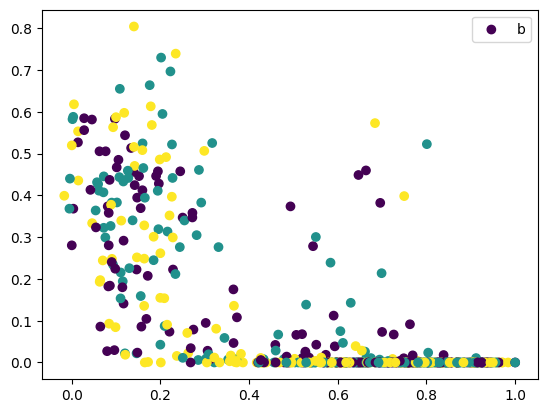

In [283]:
plt.scatter(full_pq_data["lambda"], full_pq_data['diff'], c= full_pq_data['data_size'], cmap = )
plt.legend()

In [282]:
full_pq_data['data_size'].apply(str)

0     30
1     30
2     30
3     50
4     50
      ..
85    50
86    50
87    70
88    70
89    70
Name: data_size, Length: 540, dtype: object